# CARIACO PROJECT '1' - Final Plotting
# Plot boxplot of functional types
- ordered according to biomass
- ordered according to size

In [1]:
#load required packages:
require(tidyverse, warn.conflicts = FALSE); # many useful data analysis tools
require(cowplot, warn.conflicts = FALSE); # for nicer plots, includes ggplot2
require(oce, warn.conflicts = FALSE); # includes the used "integrateTrapezoid" function
require(pracma)

Loading required package: tidyverse
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: cowplot
Loading required package: oce
Loading required package: testthat

Attaching package: ‘testthat’

The following object is masked from ‘package:dplyr’:

    matches

The following object is masked from ‘package:purrr’:

    is_null

Loading required package: gsw
Loading required package: pracma

A

In [2]:
# Function to read specific functional type data from dataset
## checks for number of NAs and removes them from resulting dataframe
extractfunctype <- function(FullFT_df, ft='Diatoms_Hapto1', reg=1){
    if(reg==1){
        date = 'Date'
        depth = 'depth'
        ft = ft
    }else{
        date = 'X2Date'
        depth = 'X2depth'
        ft = paste('X2',ft, sep="")
    }
        
    FT_df_x <- data.frame("date" = FullFT_df[,date], "depth" = FullFT_df[,depth], "value" = FullFT_df[,ft])
    
    # print(head(FT_df_x))
    # print( length(is.na(FT_df_x$date)) )
    
    FT_df <- FT_df_x[complete.cases(FT_df_x),]
    
    return(FT_df)
}

In [3]:
# debugging:
# head(extractfunctype(FuncTypeChlA, ft="Diatoms_Hapto1", reg=1))

In [4]:
depthmean <-function(DF){
    DF_1 <- DF %>%
        group_by(date, depth) %>%
        # averaging multiple measurements at same depth here
        # also converting ng/l to mg/m^-3 
        summarise(value = mean(value)/1000) %>%
        ungroup()
    
    depth_all <- c(1,7,15,25,35,55,75,100)
    
    DF_2 <- DF_1 %>%
        group_by(date) %>%
        complete(date, depth=depth_all) %>%
        fill(value) %>% #default direction down
        fill(value, .direction = "up")
    
    return(DF_2)
}

# adapt interpolation function from PINCKNEY
ntpltJAYfunc <- function(x, y){
    N1 = length(y)
    area = 0
    
    for(j in 2:N1){
        area = area + (x[j] - x[j-1]) * (y[j] + y[j-1]) / 2
    }
    
    return(area)
}

intrpltJAY <- function(DFtest, reg, spec){
    DF_int <- DFtest %>%
        group_by(date) %>%
        do(data.frame("value_int" = with(.,ntpltJAYfunc(x=depth, y=value)), "reg" = reg , "spec" = spec)) %>%
        ungroup()
        
    return(DF_int)
}

In [5]:
extractnintegrate <- function(data = FullFT_df, functype='Diatoms_Hapto1', regime=1){
    #calling extraction function
    DF <- extractfunctype(data, ft = functype, reg = regime)
    
    #take mean of duplicate sample, and fill unsampled depth with depth below or above (depending on position)
    DF_1 <- depthmean(DF)
    
    #remove NAs at end of DF
    DF_2 <- na.omit(DF_1)
    
    DF_int <- intrpltJAY(DF_2, regime, functype) 
    
    #%>%   group_by(date) %>%
    #    filter(sum(!is.na(value))>2) %>%
    #    do(data.frame(middepth = as.numeric(stats::filter(.$depth, c(0.5,0.5))), midval = as.numeric(stats::filter(.$value, c(0.5,0.5))))) %>%
    #    ungroup()

    #DFtest <- na.omit(DFtest)

    #DF_int <- DFtest %>%
    #    group_by(date) %>%
    #    do(data.frame("value_int" = with(.,integrateTrapezoid(x=middepth, y=midval)), "reg" = regime , "spec" = functype)) %>%
    #    ungroup()
    return(DF_int)
    
}

In [6]:
# debugging:
# D1_int <- extractnintegrate(data=FuncTypeChlA, functype="Diatoms_Hapto1", regime=1)

## read data from csv.
data courtesy of JP & CBN

In [7]:
FuncTypeChlA <- read.csv("CARIACO Data for Algal Group Plots.csv")
FuncTypeChlA$Date <- as.Date(as.character(FuncTypeChlA$Date), format="%m/%d/%y")
FuncTypeChlA$X2Date <- as.Date(as.character(FuncTypeChlA$X2Date), format="%m/%d/%y")

In [8]:
cat(colnames(FuncTypeChlA), sep='  -  ')

Date  -  depth  -  Prasinophytes  -  Dinoflagellates  -  Cryptophytes  -  Haptophytes2  -  Chlorophytes  -  Cyanobacteria  -  Diatoms_Hapto1  -  Hapto3_Hapto4  -  X2Date  -  X2depth  -  X2Prasinophytes  -  X2Dinoflagellates  -  X2Cryptophytes  -  X2Haptophytes2  -  X2Chlorophytes  -  X2Cyanobacteria  -  X2Diatoms_Hapto1  -  X2Hapto3_Hapto4

## interpolate all individual functional types

In [9]:
Di1_int <- extractnintegrate(data=FuncTypeChlA, functype="Diatoms_Hapto1", regime=1)
Di2_int <- extractnintegrate(data=FuncTypeChlA, functype="Diatoms_Hapto1", regime=2)

Co1_int <- extractnintegrate(data=FuncTypeChlA, functype="Hapto3_Hapto4", regime=1)
Co2_int <- extractnintegrate(data=FuncTypeChlA, functype="Hapto3_Hapto4", regime=2)

Cy1_int <- extractnintegrate(data=FuncTypeChlA, functype="Cyanobacteria", regime=1)
Cy2_int <- extractnintegrate(data=FuncTypeChlA, functype="Cyanobacteria", regime=2)

Chl1_int <- extractnintegrate(data=FuncTypeChlA, functype="Chlorophytes", regime=1)
Chl2_int <- extractnintegrate(data=FuncTypeChlA, functype="Chlorophytes", regime=2)

H21_int <- extractnintegrate(data=FuncTypeChlA, functype="Haptophytes2", regime=1)
H22_int <- extractnintegrate(data=FuncTypeChlA, functype="Haptophytes2", regime=2)

Cry1_int <- extractnintegrate(data=FuncTypeChlA, functype="Cryptophytes", regime=1)
Cry2_int <- extractnintegrate(data=FuncTypeChlA, functype="Cryptophytes", regime=2)

Dino1_int <- extractnintegrate(data=FuncTypeChlA, functype="Dinoflagellates", regime=1)
Dino2_int <- extractnintegrate(data=FuncTypeChlA, functype="Dinoflagellates", regime=2)

Pr1_int <- extractnintegrate(data=FuncTypeChlA, functype="Prasinophytes", regime=1)
Pr2_int <- extractnintegrate(data=FuncTypeChlA, functype="Prasinophytes", regime=2)

In [10]:
tail(Di1_int)

date,value_int,reg,spec
2000-05-11,16.409510,1,Diatoms_Hapto1
2000-06-06,4.632600,1,Diatoms_Hapto1
2000-07-07,3.069110,1,Diatoms_Hapto1
2000-08-09,4.516635,1,Diatoms_Hapto1
2000-09-12,15.468800,1,Diatoms_Hapto1
2000-10-10,3.125250,1,Diatoms_Hapto1


## combine into large dataframe

In [11]:
FT_ALL <- rbind(Di1_int,Di2_int, Co1_int,Co2_int, Cy1_int,Cy2_int, Chl1_int,Chl2_int, H21_int,H22_int, Cry1_int,Cry2_int, Dino1_int,Dino2_int, Pr1_int,Pr2_int)

In [12]:
FT_ALL$reg <- as.factor(FT_ALL$reg)
head(FT_ALL)

date,value_int,reg,spec
1995-12-14,5.866175,1,Diatoms_Hapto1
1996-01-13,29.020890,1,Diatoms_Hapto1
1996-02-14,20.237395,1,Diatoms_Hapto1
1996-03-13,14.925140,1,Diatoms_Hapto1
1996-04-17,101.297110,1,Diatoms_Hapto1
1996-05-10,31.409455,1,Diatoms_Hapto1


In [13]:
FT_ALL$spec <- factor(FT_ALL$spec, levels = c("Prasinophytes","Dinoflagellates","Cryptophytes","Hapto3_Hapto4", "Chlorophytes","Cyanobacteria","Haptophytes2","Diatoms_Hapto1"),ordered = TRUE)

In [14]:
FT_means <- aggregate(value_int ~  reg + spec, FT_ALL, mean)
FT_means$depint_mean <- FT_means$value_int
FT_means$depint_mean_rounded <- round(FT_means$depint_mean, digits = 2)

FT_medians <- aggregate(value_int ~  reg + spec, FT_ALL, median)

FT_means$depint_median <- FT_medians$value_int
FT_means$depint_median_rounded <- round(FT_means$depint_median, digits = 2)

tail(FT_means)

,reg,spec,value_int,depint_mean,depint_mean_rounded,depint_median,depint_median_rounded
11,1,Cyanobacteria,1.504810,1.504810,1.50,1.289980,1.29
12,2,Cyanobacteria,2.752790,2.752790,2.75,2.536230,2.54
13,1,Haptophytes2,1.844375,1.844375,1.84,0.699940,0.70
14,2,Haptophytes2,3.106995,3.106995,3.11,2.277605,2.28
15,1,Diatoms_Hapto1,16.882573,16.882573,16.88,13.056410,13.06
16,2,Diatoms_Hapto1,12.833542,12.833542,12.83,8.550245,8.55


In [15]:
# now check for biomass ranking of all types:
FT_means[order(FT_means$depint_mean, decreasing = T),]

FT_means_sum <- FT_means %>%
    group_by(spec) %>%
    summarise(meansum = sum(depint_mean)) %>%
    arrange(desc(meansum))

,reg,spec,value_int,depint_mean,depint_mean_rounded,depint_median,depint_median_rounded
15,1,Diatoms_Hapto1,16.8825734,16.8825734,16.88,13.056410,13.06
16,2,Diatoms_Hapto1,12.8335422,12.8335422,12.83,8.550245,8.55
8,2,Hapto3_Hapto4,7.5209841,7.5209841,7.52,6.519075,6.52
7,1,Hapto3_Hapto4,6.4183140,6.4183140,6.42,4.270705,4.27
14,2,Haptophytes2,3.1069946,3.1069946,3.11,2.277605,2.28
2,2,Prasinophytes,2.7538680,2.7538680,2.75,2.671670,2.67
12,2,Cyanobacteria,2.7527903,2.7527903,2.75,2.536230,2.54
6,2,Cryptophytes,2.6828338,2.6828338,2.68,2.203565,2.20
1,1,Prasinophytes,2.1947344,2.1947344,2.19,1.728935,1.73
13,1,Haptophytes2,1.8443754,1.8443754,1.84,0.699940,0.70


# create PLOT ordered by BIOMASS

In [16]:
FT_ALL$spec <- factor(FT_ALL$spec, levels = FT_means_sum$spec ,ordered = TRUE)

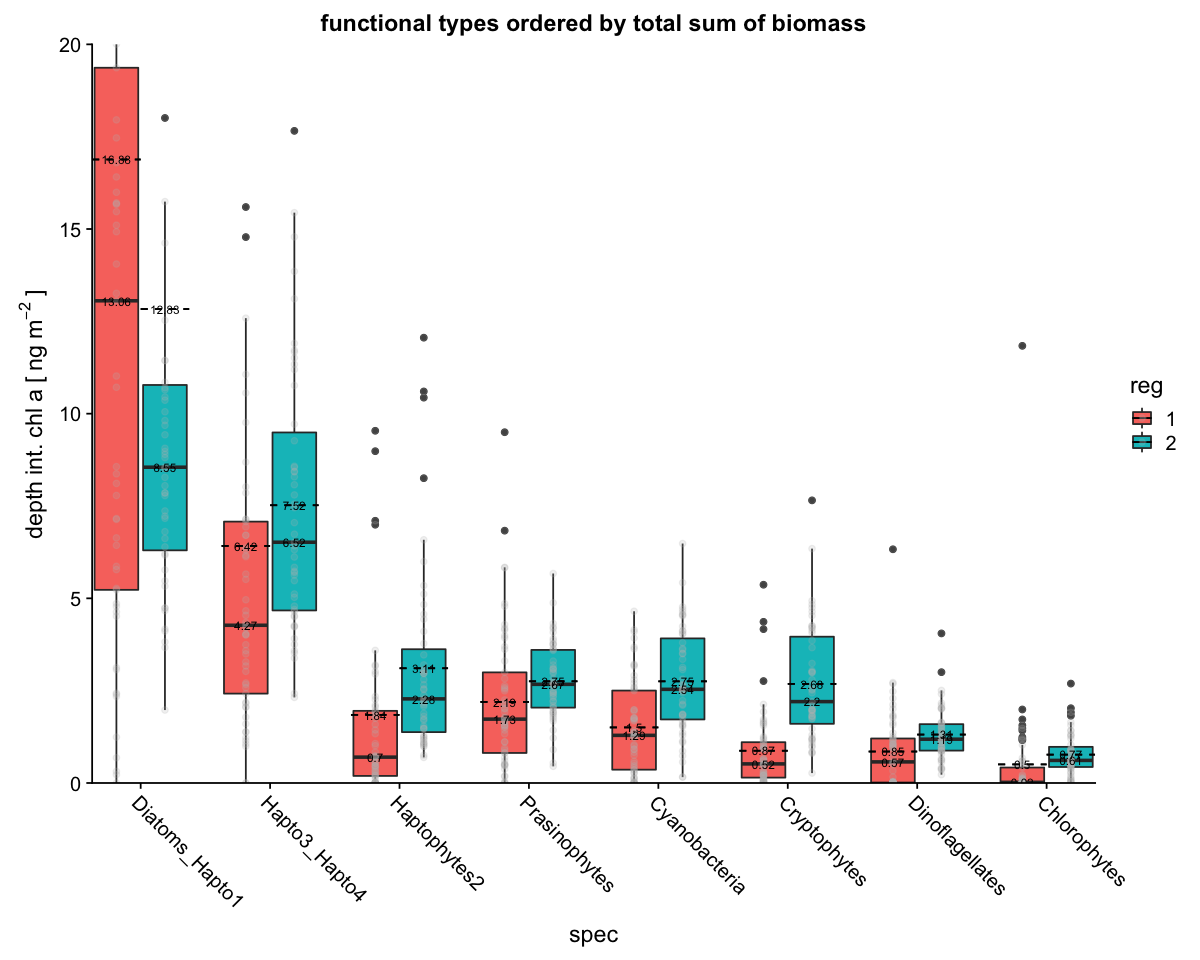

In [17]:
options(repr.plot.width=10, repr.plot.height=8)
ggplot(data = FT_ALL, aes(y = value_int, x = spec, fill = reg)) + 
geom_boxplot() + geom_jitter(position = position_dodge(width = .75), col='grey', alpha=0.2) + ylab(expression(depth~int.~chl~a~'['~ng~m^{-2}~']')) + coord_cartesian(ylim=c(0,20), expand=F)+

stat_summary(fun.y = mean, geom = "errorbar", 
               aes(ymax = ..y.., ymin = ..y.., group = reg),
               width = 0.75, linetype = "dashed", position = position_dodge(), show.legend=T)+
               
#stat_summary(fun.y=mean, colour='red', geom="point", shape=18, size=3,show_guide = FALSE)

#geom_point(data = FT_means, aes(y=depint_mean, shape='d', col = 'black', group=col), show.legend = T) #+ 
geom_text(data = FT_means, aes(label = depint_mean_rounded, y = depint_mean, group = reg, x=spec),  show.legend = F, size=2.5, position = position_dodge(width = .75)) + #nudge_x = -0.3,
geom_text(data = FT_means, aes(label = depint_median_rounded, y = depint_median, group = reg, x=spec), show.legend = F, size=2.5, position = position_dodge(width = .75))+ #, nudge_x = 0.3
theme(axis.text.x=element_text(angle=-45, hjust=0)) + ggtitle('functional types ordered by total sum of biomass')

In [18]:
ggsave("functypecomp.pdf", width = 10, height = 5)

# plot with new grouping, 5 FTs

In [19]:
#combine all haptophytes into a group
Hapto1_int <- merge(Co1_int, H21_int, by="date")

Hapto1_int$value_int <- Hapto1_int$value_int.x + Hapto1_int$value_int.y
Hapto1_int$reg <- Hapto1_int$reg.x
Hapto1_int$spec <- "Haptophytes"

head(Hapto1_int)

date,value_int.x,reg.x,spec.x,value_int.y,reg.y,spec.y,value_int,reg,spec
1995-12-14,2.669755,1,Hapto3_Hapto4,0.000000,1,Haptophytes2,2.669755,1,Haptophytes
1996-01-13,3.022600,1,Hapto3_Hapto4,2.259850,1,Haptophytes2,5.282450,1,Haptophytes
1996-02-14,2.183970,1,Hapto3_Hapto4,0.589445,1,Haptophytes2,2.773415,1,Haptophytes
1996-03-13,2.055860,1,Hapto3_Hapto4,0.699940,1,Haptophytes2,2.755800,1,Haptophytes
1996-04-17,50.814910,1,Hapto3_Hapto4,0.013800,1,Haptophytes2,50.828710,1,Haptophytes
1996-05-10,9.761115,1,Hapto3_Hapto4,0.153500,1,Haptophytes2,9.914615,1,Haptophytes


In [20]:
Hapto2_int <- merge(Co2_int, H22_int, by="date")

Hapto2_int$value_int <- Hapto2_int$value_int.x + Hapto2_int$value_int.y
Hapto2_int$reg <- Hapto2_int$reg.x
Hapto2_int$spec <- "Haptophytes"

head(Hapto2_int)

date,value_int.x,reg.x,spec.x,value_int.y,reg.y,spec.y,value_int,reg,spec
2006-07-04,2.318240,2,Hapto3_Hapto4,0.754935,2,Haptophytes2,3.073175,2,Haptophytes
2006-08-03,5.699350,2,Hapto3_Hapto4,2.277605,2,Haptophytes2,7.976955,2,Haptophytes
2006-09-12,5.840110,2,Hapto3_Hapto4,2.176150,2,Haptophytes2,8.016260,2,Haptophytes
2006-10-10,7.049195,2,Hapto3_Hapto4,10.434290,2,Haptophytes2,17.483485,2,Haptophytes
2006-11-02,5.629300,2,Hapto3_Hapto4,1.049180,2,Haptophytes2,6.678480,2,Haptophytes
2006-12-05,7.454865,2,Hapto3_Hapto4,1.543220,2,Haptophytes2,8.998085,2,Haptophytes


In [21]:
Other1_int_part1 <- merge(Pr1_int, Cry1_int, by="date")
Other1_int <- merge(Other1_int_part1, Chl1_int, by="date")

Other1_int$value_int <- Other1_int$value_int.x + Other1_int$value_int.y + Other1_int$value_int
Other1_int$reg <- Other1_int$reg.x
Other1_int$spec <- "Others (Pr,Cry,Chl)"

head(Other1_int)

date,value_int.x,reg.x,spec.x,value_int.y,reg.y,spec.y,value_int,reg,spec
1995-12-14,2.545420,1,Prasinophytes,0.663840,1,Cryptophytes,3.209260,1,"Others (Pr,Cry,Chl)"
1996-01-13,1.433025,1,Prasinophytes,1.080450,1,Cryptophytes,3.103075,1,"Others (Pr,Cry,Chl)"
1996-02-14,1.644840,1,Prasinophytes,1.929655,1,Cryptophytes,3.574495,1,"Others (Pr,Cry,Chl)"
1996-03-13,0.493430,1,Prasinophytes,0.922610,1,Cryptophytes,1.510190,1,"Others (Pr,Cry,Chl)"
1996-04-17,1.110420,1,Prasinophytes,2.759630,1,Cryptophytes,15.706960,1,"Others (Pr,Cry,Chl)"
1996-05-10,1.113285,1,Prasinophytes,0.215870,1,Cryptophytes,2.360430,1,"Others (Pr,Cry,Chl)"


In [22]:
Other2_int_part1 <- merge(Pr2_int, Cry2_int, by="date")
Other2_int <- merge(Other2_int_part1, Chl2_int, by="date")

Other2_int$value_int <- Other2_int$value_int.x + Other2_int$value_int.y + Other2_int$value_int
Other2_int$reg <- Other2_int$reg.x
Other2_int$spec <- "Others (Pr,Cry,Chl)"

head(Other2_int)

date,value_int.x,reg.x,spec.x,value_int.y,reg.y,spec.y,value_int,reg,spec
2006-07-04,2.101050,2,Prasinophytes,0.268300,2,Cryptophytes,2.393950,2,"Others (Pr,Cry,Chl)"
2006-08-03,2.367625,2,Prasinophytes,1.985785,2,Cryptophytes,4.547620,2,"Others (Pr,Cry,Chl)"
2006-09-12,2.973370,2,Prasinophytes,1.805165,2,Cryptophytes,4.881705,2,"Others (Pr,Cry,Chl)"
2006-10-10,1.218260,2,Prasinophytes,1.805010,2,Cryptophytes,4.292025,2,"Others (Pr,Cry,Chl)"
2006-11-02,2.711655,2,Prasinophytes,1.470970,2,Cryptophytes,4.277475,2,"Others (Pr,Cry,Chl)"
2006-12-05,4.318435,2,Prasinophytes,1.734465,2,Cryptophytes,6.605110,2,"Others (Pr,Cry,Chl)"


In [23]:
NewComb_FT_ALL <- bind_rows(Di1_int,Di2_int, Hapto1_int, Hapto2_int, Cy1_int,Cy2_int, Dino1_int,Dino2_int, Other1_int, Other2_int)
head(NewComb_FT_ALL)

Warning message in bind_rows_(x, .id):
“binding factor and character vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“Unequal fac

date,value_int,reg,spec,value_int.x,reg.x,spec.x,value_int.y,reg.y,spec.y
1995-12-14,5.866175,1,Diatoms_Hapto1,NA,NA,NA,NA,NA,NA
1996-01-13,29.020890,1,Diatoms_Hapto1,NA,NA,NA,NA,NA,NA
1996-02-14,20.237395,1,Diatoms_Hapto1,NA,NA,NA,NA,NA,NA
1996-03-13,14.925140,1,Diatoms_Hapto1,NA,NA,NA,NA,NA,NA
1996-04-17,101.297110,1,Diatoms_Hapto1,NA,NA,NA,NA,NA,NA
1996-05-10,31.409455,1,Diatoms_Hapto1,NA,NA,NA,NA,NA,NA


In [24]:
NewComb_FT_ALL$reg <- as.factor(NewComb_FT_ALL$reg)
head(NewComb_FT_ALL)

date,value_int,reg,spec,value_int.x,reg.x,spec.x,value_int.y,reg.y,spec.y
1995-12-14,5.866175,1,Diatoms_Hapto1,NA,NA,NA,NA,NA,NA
1996-01-13,29.020890,1,Diatoms_Hapto1,NA,NA,NA,NA,NA,NA
1996-02-14,20.237395,1,Diatoms_Hapto1,NA,NA,NA,NA,NA,NA
1996-03-13,14.925140,1,Diatoms_Hapto1,NA,NA,NA,NA,NA,NA
1996-04-17,101.297110,1,Diatoms_Hapto1,NA,NA,NA,NA,NA,NA
1996-05-10,31.409455,1,Diatoms_Hapto1,NA,NA,NA,NA,NA,NA


In [25]:
write.csv(NewComb_FT_ALL, file = "../DATA_processed/NewComb_FT_all_PinckneyHPLC.csv")

In [26]:
#T_ALL$spec <- factor(FT_ALL$spec, levels = c("Prasinophytes","Dinoflagellates","Cryptophytes","Hapto3_Hapto4", "Chlorophytes","Cyanobacteria","Haptophytes2","Diatoms_Hapto1"),ordered = TRUE)

In [27]:
NewComb_FT_means <- aggregate(value_int ~  reg + spec, NewComb_FT_ALL, mean)
NewComb_FT_means$depint_mean <- NewComb_FT_means$value_int
NewComb_FT_means$depint_mean_rounded <- round(NewComb_FT_means$depint_mean, digits = 2)

NewComb_FT_medians <- aggregate(value_int ~  reg + spec, NewComb_FT_ALL, median)

NewComb_FT_means$depint_median <- NewComb_FT_medians$value_int
NewComb_FT_means$depint_median_rounded <- round(NewComb_FT_means$depint_median, digits = 2)

tail(NewComb_FT_means)

,reg,spec,value_int,depint_mean,depint_mean_rounded,depint_median,depint_median_rounded
5,1,Dinoflagellates,0.8519487,0.8519487,0.85,0.571315,0.57
6,2,Dinoflagellates,1.3109905,1.3109905,1.31,1.185640,1.19
7,1,Haptophytes,8.2626894,8.2626894,8.26,6.235035,6.24
8,2,Haptophytes,10.6279786,10.6279786,10.63,10.357915,10.36
9,1,"Others (Pr,Cry,Chl)",3.5713434,3.5713434,3.57,3.116505,3.12
10,2,"Others (Pr,Cry,Chl)",6.2044300,6.2044300,6.20,6.257745,6.26


In [37]:
NewComb_FT_sum <- aggregate(value_int ~  spec, NewComb_FT_ALL, sum)
NewComb_FT_sum$depint_sum <- NewComb_FT_sum$value_int
NewComb_FT_sum$depint_sum_rounded <- round(NewComb_FT_sum$depint_sum, digits = 2)

TOT <- sum(NewComb_FT_sum$depint_sum)
NewComb_FT_sum$percent <- NewComb_FT_sum$depint_sum/TOT


NewComb_FT_sum

spec,value_int,depint_sum,depint_sum_rounded,percent
Cyanobacteria,226.1665,226.1665,226.17,0.06477820
Diatoms_Hapto1,1616.8173,1616.8173,1616.82,0.46308593
Dinoflagellates,115.4216,115.4216,115.42,0.03305885
Haptophytes,1013.0002,1013.0002,1013.00,0.29014170
"Others (Pr,Cry,Chl)",519.9925,519.9925,519.99,0.14893532


In [31]:
# now check for biomass ranking of all types:
NewComb_FT_means[order(NewComb_FT_means$depint_mean, decreasing = T),]

NewComb_FT_means_sum <- NewComb_FT_means %>%
    group_by(spec) %>%
    summarise(meansum = sum(depint_mean)) %>%
    arrange(desc(meansum))

total <- sum(NewComb_FT_means_sum$meansum)
NewComb_FT_means_sum$percent <- NewComb_FT_means_sum$meansum/total
NewComb_FT_means_sum

,reg,spec,value_int,depint_mean,depint_mean_rounded,depint_median,depint_median_rounded
3,1,Diatoms_Hapto1,16.8825734,16.8825734,16.88,13.056410,13.06
4,2,Diatoms_Hapto1,12.8335422,12.8335422,12.83,8.550245,8.55
8,2,Haptophytes,10.6279786,10.6279786,10.63,10.357915,10.36
7,1,Haptophytes,8.2626894,8.2626894,8.26,6.235035,6.24
10,2,"Others (Pr,Cry,Chl)",6.2044300,6.2044300,6.20,6.257745,6.26
9,1,"Others (Pr,Cry,Chl)",3.5713434,3.5713434,3.57,3.116505,3.12
2,2,Cyanobacteria,2.7527903,2.7527903,2.75,2.536230,2.54
1,1,Cyanobacteria,1.5048103,1.5048103,1.50,1.289980,1.29
6,2,Dinoflagellates,1.3109905,1.3109905,1.31,1.185640,1.19
5,1,Dinoflagellates,0.8519487,0.8519487,0.85,0.571315,0.57


spec,meansum,percent
Diatoms_Hapto1,29.716116,0.45856012
Haptophytes,18.890668,0.29150872
"Others (Pr,Cry,Chl)",9.775773,0.15085349
Cyanobacteria,4.257601,0.06570057
Dinoflagellates,2.162939,0.03337710


# create PLOT ordered by BIOMASS

In [73]:
NewComb_FT_ALL$spec <- factor(NewComb_FT_ALL$spec, levels = NewComb_FT_means_sum$spec ,ordered = TRUE)

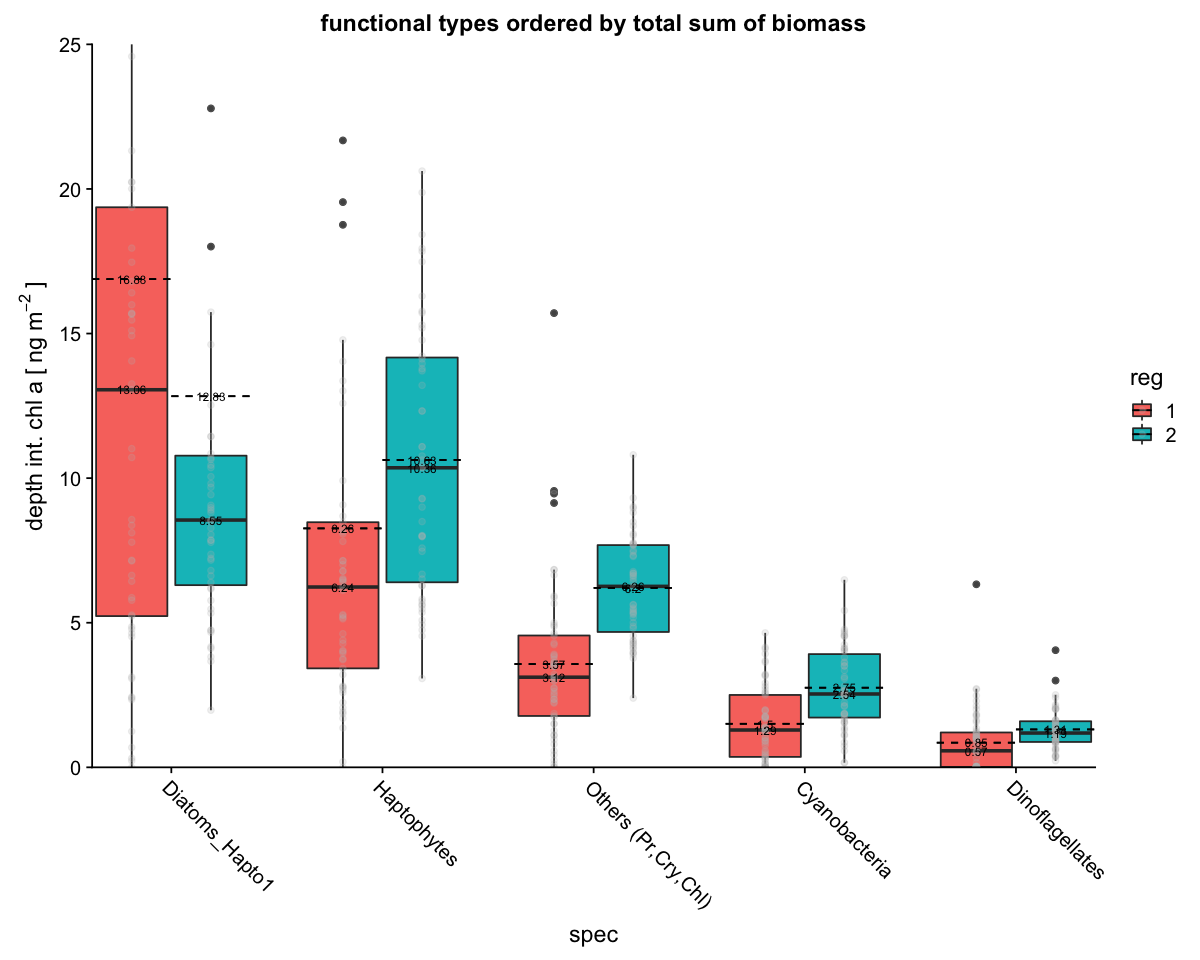

In [79]:
options(repr.plot.width=10, repr.plot.height=8)
ggplot(data = NewComb_FT_ALL, aes(y = value_int, x = spec, fill = reg)) + 
geom_boxplot() + geom_jitter(position = position_dodge(width = .75), col='grey', alpha=0.2) + ylab(expression(depth~int.~chl~a~'['~ng~m^{-2}~']')) + coord_cartesian(ylim=c(0,25), expand=F)+

stat_summary(fun.y = mean, geom = "errorbar", 
               aes(ymax = ..y.., ymin = ..y.., group = reg),
               width = 0.75, linetype = "dashed", position = position_dodge(), show.legend=T)+
               
#stat_summary(fun.y=mean, colour='red', geom="point", shape=18, size=3,show_guide = FALSE)

#geom_point(data = FT_means, aes(y=depint_mean, shape='d', col = 'black', group=col), show.legend = T) #+ 
geom_text(data = NewComb_FT_means, aes(label = depint_mean_rounded, y = depint_mean, group = reg, x=spec),  show.legend = F, size=2.5, position = position_dodge(width = .75)) + #nudge_x = -0.3,
geom_text(data = NewComb_FT_means, aes(label = depint_median_rounded, y = depint_median, group = reg, x=spec), show.legend = F, size=2.5, position = position_dodge(width = .75))+ #, nudge_x = 0.3
theme(axis.text.x=element_text(angle=-45, hjust=0)) + ggtitle('functional types ordered by total sum of biomass')

In [80]:
ggsave("newcombfunctypecomp.pdf", width = 10, height = 10)

# new plot ordered by CELL SIZE

## first need to find out rough cell sizes for these functional groups present @cariaco

Diatoms:  
Reg1 & Reg2:  
pseudonitzschia delicatissima 19-76 µm * 1.5-2 µm  tapered towards end, in mexico 34 x 1.8 in size 
>(https://www.researchgate.net/profile/Nina_Lundholm/publication/222717248_Morphology_physiology_molecular_phylogeny_and_sexual_compatibility_of_the_cryptic_Pseudo-nitzschia_delicatissima_complex_Bacillariophyta_including_the_description_of_P_arenysensis_sp_nov/links/577a1b4d08aeb9427e2cabb2/Morphology-physiology-molecular-phylogeny-and-sexual-compatibility-of-the-cryptic-Pseudo-nitzschia-delicatissima-complex-Bacillariophyta-including-the-description-of-P-arenysensis-sp-nov.pdf)

Reg1 only:


Reg 2 only:
thalassiosira subtilis 17-34 µm diatmeter centric 
>(https://sci-hub.tw/10.1515/bot.1999.056, Aké-Castillo, J. A., Hernández-Becerril, D. U., & Meave del Castillo, M. E. (1999). Species of the Genus Thalassiosira (Bacillariophyceae) from the Gulf of Tehuantepec, Mexico. Botanica Marina, 42(6). doi:10.1515/bot.1999.056 )

leptocylindrus minimus Diámetro: 2-5.2 µm; eje pervalvar: 22-48 µm. 
>(https://scielo.conicyt.cl/scielo.php?pid=S0717-66432002000100002&script=sci_arttext)

chaetocerus compressus apical axis, 8.5-24 µm
>(https://www.redalyc.org/pdf/479/47943208.pdf)



COCCOS:
Emiliania huxleyi Diameter c. 5-10 µm
>Google

Haptophytes2



# test original pinckney data, and perhaps continue using it!

In [20]:
PinckINTchla <- read.csv("IntegratedValues_PINCKNEY.csv", dec=',', sep=';')

In [21]:
head(PinckINTchla)

Year,Month,Day,Date,Depth,Date.1,Tchla,Prasino3,Dino1,Crypto1,Hapto6,Chloro1,Cyano4,Diatom1
1995,Dec,14,12.14.95,0 - 55 m,14-Dec-95,11.34,1.93,0.85,0.66,2.13,0.00,0.66,5.10
1996,Jan,13,01.13.96,0 - 55 m,13. Jan 96,41.94,0.96,6.23,1.08,2.55,0.59,0.40,27.86
1996,Feb,14,02.14.96,0 - 55 m,14. Feb 96,25.44,1.08,1.79,1.81,1.79,0.00,0.25,18.14
1996,0,13,03.13.96,0 - 55 m,13-Mar-96,20.21,0.37,1.80,0.92,1.84,0.09,0.25,14.23
1996,Apr,17,04.17.96,0 - 55 m,17. Apr 96,167.78,0.84,2.72,2.76,50.01,11.79,1.35,98.30
1996,May,10,05.10.96,0 - 55 m,10-May-96,42.38,0.92,0.01,0.22,9.38,1.03,0.53,30.14


In [22]:
PinckINTchla$Date <- as.Date(as.character(PinckINTchla$Date), format="%m.%d.%y")

In [23]:
PINT1 <- PinckINTchla[PinckINTchla$Depth == "0 - 55 m",]
PINT2 <- PinckINTchla[PinckINTchla$Depth == "55 - 100 m",]

In [24]:
PINT <- merge(PINT1,PINT2, by="Date")

In [25]:
PINT$Tchla <- PINT$Tchla.x + PINT$Tchla.y
PINT$Prasino3 <- PINT$Prasino3.x + PINT$Prasino3.y
PINT$Crypto1 <- PINT$Crypto1.x + PINT$Crypto1.y
PINT$Hapto6 <- PINT$Hapto6.x + PINT$Hapto6.y
PINT$Chloro1 <- PINT$Chloro1.x + PINT$Chloro1.y
PINT$Cyano4 <- PINT$Cyano4.x + PINT$Cyano4.y
PINT$Diatom1 <- PINT$Diatom1.x + PINT$Diatom1.y

In [26]:
Tchla    <- data.frame('Date'=PINT$Date, 'val'=PINT$Tchla,   'spec'='Tchla')
Prasino3 <- data.frame('Date'=PINT$Date, 'val'=PINT$Prasino3,'spec'='Prasino3')
Crypto1  <- data.frame('Date'=PINT$Date, 'val'=PINT$Crypto1, 'spec'='Crypto1')
Hapto6   <- data.frame('Date'=PINT$Date, 'val'=PINT$Hapto6,  'spec'='Hapto6')
Chloro1  <- data.frame('Date'=PINT$Date, 'val'=PINT$Chloro1, 'spec'='Chloro1')
Cyano4   <- data.frame('Date'=PINT$Date, 'val'=PINT$Cyano4,  'spec'='Cyano4')
Diatom1  <- data.frame('Date'=PINT$Date, 'val'=PINT$Diatom1, 'spec'='Diatom1')

In [27]:
PINTDF <- rbind(Tchla, Prasino3, Crypto1, Hapto6, Chloro1, Cyano4, Diatom1)

In [28]:
#split data into two regimes:
PINTDF_R1 <- PINTDF[!PINTDF$Date>as.Date('2000-10-30') & !PINTDF$Date<as.Date('1996-01-01'),]
PINTDF_R2 <- PINTDF[!PINTDF$Date<as.Date('2006-06-30') & !PINTDF$Date>as.Date('2010-12-31'),]

PINTDF_R1$reg <- '1'
PINTDF_R2$reg <- '2'

In [29]:
PINTDF_RR <- rbind(PINTDF_R1,PINTDF_R2)

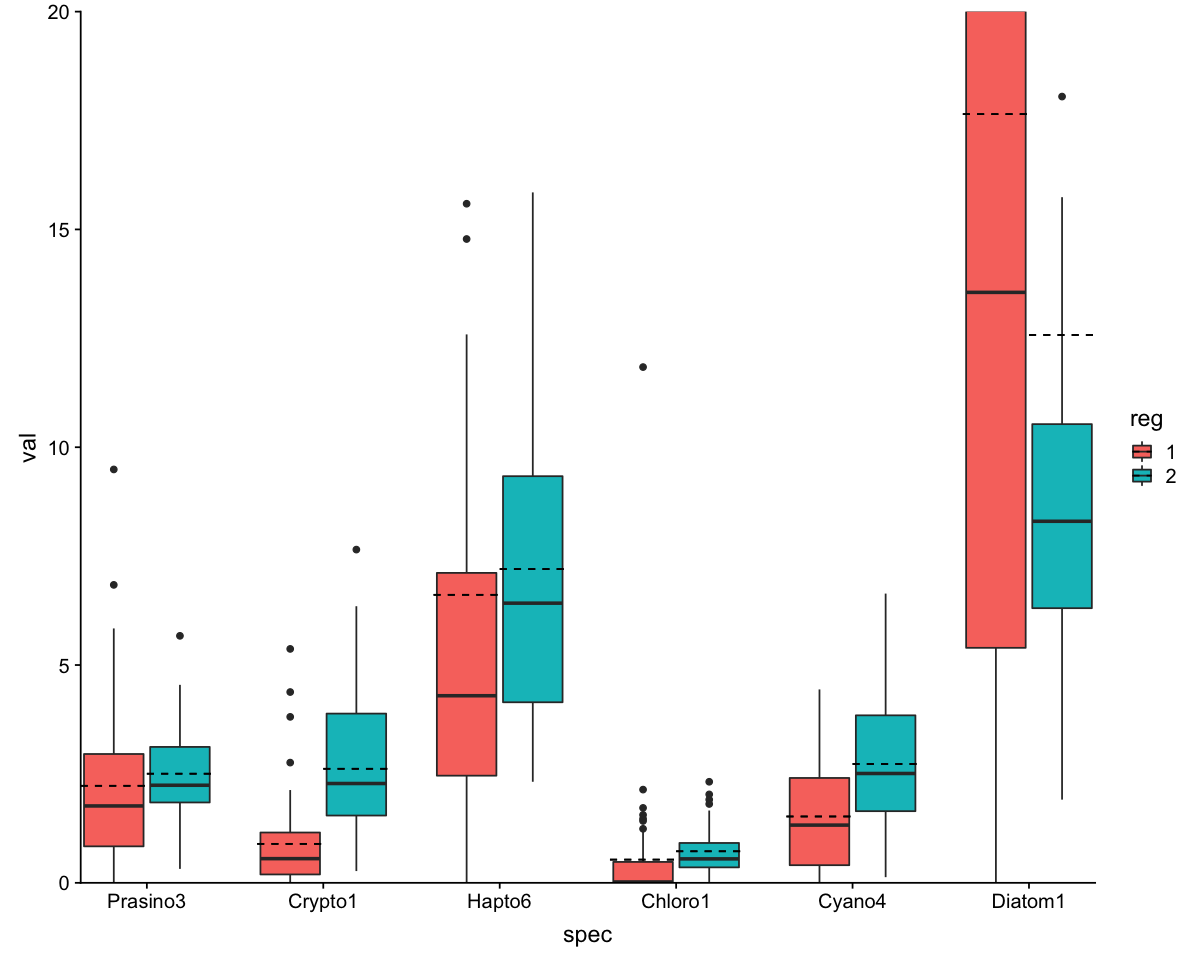

In [30]:
ggplot(data = PINTDF_RR[PINTDF_RR$spec != 'Tchla',], aes(x=spec,y=val, fill = reg)) + geom_boxplot() +

stat_summary(fun.y = mean, geom = "errorbar", 
               aes(ymax = ..y.., ymin = ..y.., group = reg),
               width = 0.75, linetype = "dashed", position = position_dodge(), show.legend=T)+
coord_cartesian(ylim=c(0,20), expand=F)

In [76]:
options(repr.plot.width=12, repr.plot.height=9)
a <- ggplot(data=PINTDF_R1[PINTDF_R1$spec != 'Tchla',], aes(x=Date,y=val, col=spec))+geom_line() + coord_cartesian(ylim=c(0,100), expand=F) + ylab('chlorophyll a [ng/m^2]')

b <- ggplot(data=PINTDF_R2[PINTDF_R2$spec != 'Tchla',], aes(x=Date,y=val, col=spec))+geom_line() + coord_cartesian(ylim=c(0,100), expand=F) + ylab('chlorophyll a [ng/m^2]')

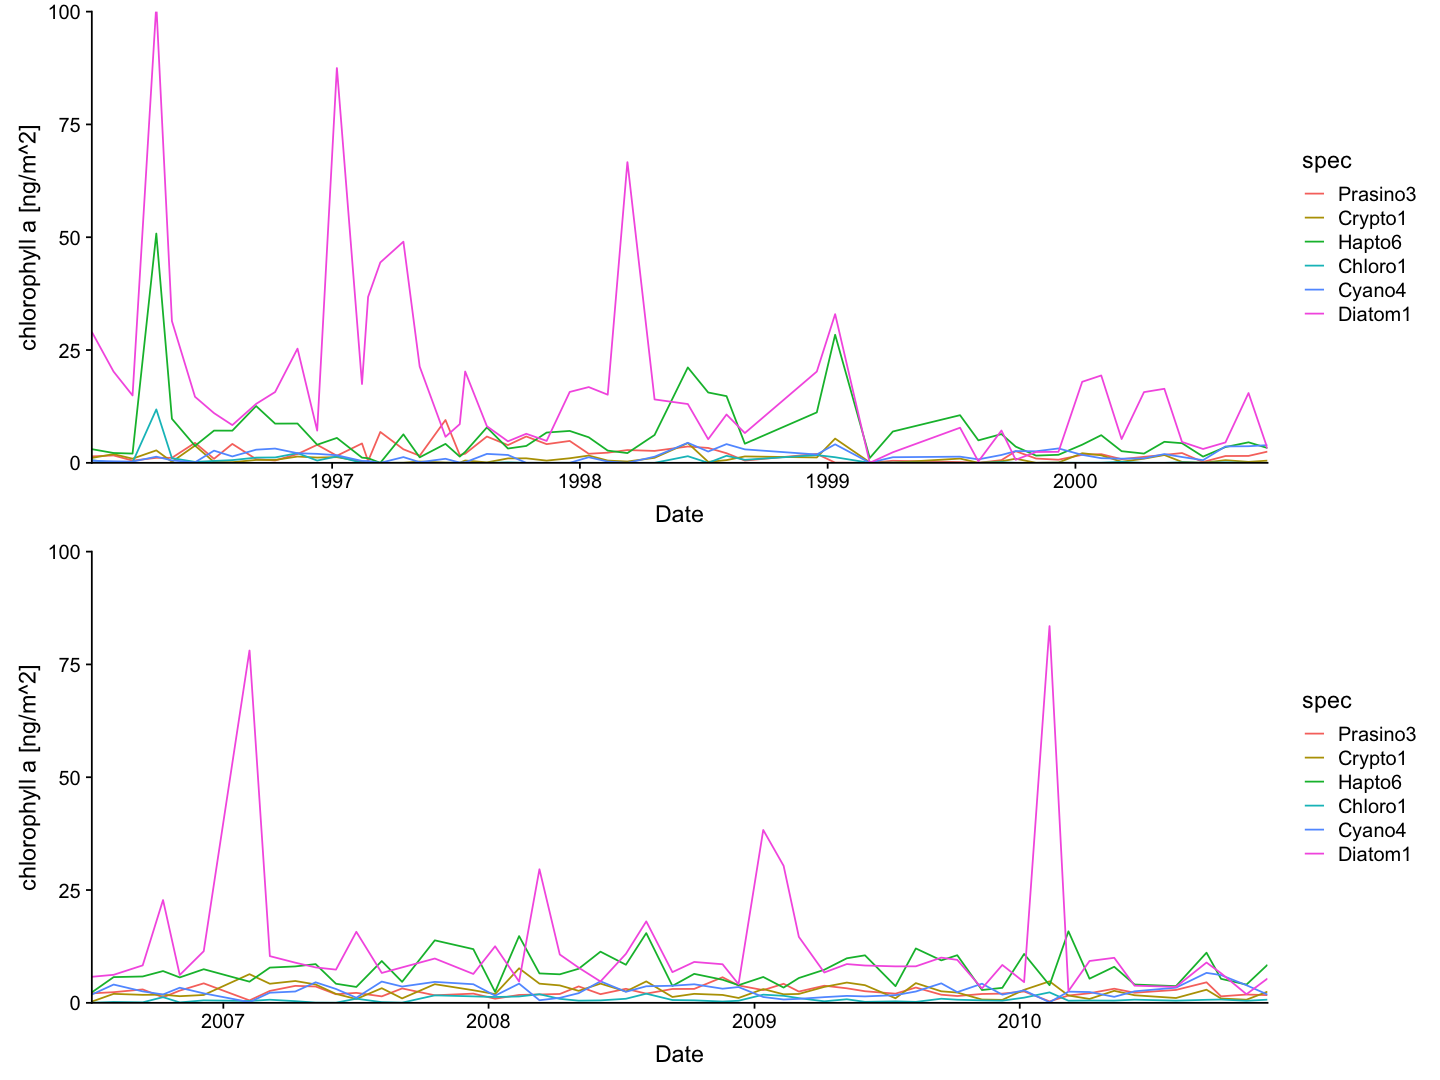

In [77]:
plot_grid(a,b, ncol=1)

In [43]:
ggsave("functypetimeseries.pdf", width = 10, height = 10)